In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
import cv2
import face_aligner as temp_fa
from face_aligner import FaceAligner
from importlib import reload
reload(temp_fa)

green = (30, 255, 13)


def alignObjectToFace(object, object_left_eye_center, object_right_eye_center, face):
    fa = FaceAligner()
    faces = fa.findFaces(face)
    if (len(faces) < 1):
        print("No faces detected")
        exit()
    face_area, x, y = faces[0]
    eyes = fa.findEyes(face_area)
    if (len(eyes) < 2):
        print("No eyes detected")
        exit()
    x1, y1, w1, h1 = eyes[0]  # Left eye area
    x1 += x
    y1 += y
    x2, y2, w2, h2 = eyes[1]  # Right eye area
    x2 += x
    y2 += y
    left_eye_center = (x1 + (w1 / 2), y1 + (h1 / 2))  # Left eye center
    right_eye_center = (x2 + (w2 / 2), y2 + (h2 / 2))  # Right eye center

    if (left_eye_center[0] > right_eye_center[0]):  # Check if eyes are switched
        left_eye_center, right_eye_center = right_eye_center, left_eye_center

    # face eyes

    dY_face = right_eye_center[1] - left_eye_center[1]
    dX_face = right_eye_center[0] - left_eye_center[0]
    # Angle of line that connects both eyes
    angle_face = np.degrees(np.arctan2(dY_face, dX_face))

    desired_distance = np.sqrt((dX_face ** 2) + (dY_face ** 2))

    # object

    dY_object = object_right_eye_center[1] - object_left_eye_center[1]
    dX_object = object_right_eye_center[0] - object_left_eye_center[0]
    # Angle of line that connects both eye positions referencing hat
    angle_object = np.degrees(np.arctan2(dY_object, dX_object))

    actual_distance = np.sqrt((dX_object ** 2) + (dY_object ** 2))

    # Knowing the distance between eyes, and based on the desired distance between eyes,
    # scale factor can be obtained

    scale_factor = desired_distance / actual_distance

    # Find eyes center
    eyes_center = ((object_left_eye_center[0] + object_right_eye_center[0]) // 2,
                   (object_left_eye_center[1] + object_right_eye_center[1]) // 2)

    M = cv2.getRotationMatrix2D(eyes_center, angle_object - angle_face, scale_factor)  # Rotation matrix

    # Update the translation component of the rotation matrix
    tX = face.shape[1] * 0.5
    tY = left_eye_center[1]

    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # Apply the affine transformation
    (w, h) = (face.shape[1], face.shape[0])
    return cv2.warpAffine(object, M, (w, h),
                            flags=cv2.INTER_CUBIC, borderValue=green)


(975, 1536, 3)
(975, 1536)
(975, 1536, 3)


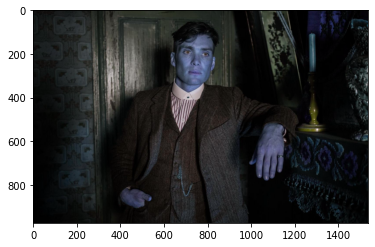

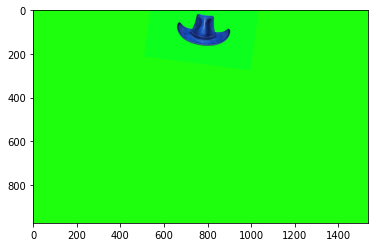

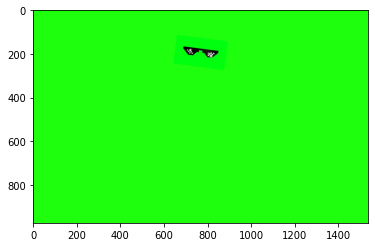

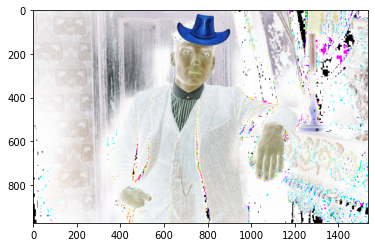

In [18]:
face = cv2.imread('cillian/cillian10.jpg')
hat = cv2.imread('objects/cowboy.jpg')
glasses = cv2.imread('objects/glasses.jpg')

# Hat eye center
hat_left_eye_center = (550, 580)
hat_right_eye_center = (770, 580)

# Glasses eye center
glasses_left_eye_center = (410, 350)
glasses_right_eye_center = (870, 350)

"""cv2.rectangle(glasses, hat_left_eye_center,
              hat_left_eye_center, (255, 0, 0), 10)
cv2.rectangle(glasses, hat_right_eye_center,
              hat_right_eye_center, (255, 0, 0), 10)
cv2.imshow('mask', glasses)

while cv2.waitKey(20) & 0xFF != ord('q'):
    pass"""

hat_normalized = alignObjectToFace(hat, hat_left_eye_center, hat_right_eye_center, face)
glasses_normalized = alignObjectToFace(
    glasses, glasses_left_eye_center, glasses_right_eye_center, face)

plt.figure()
plt.imshow(face)
plt.figure()
plt.imshow(hat_normalized)
plt.figure()
plt.imshow(glasses_normalized)

## convert to hsv
glasses_hsv = cv2.cvtColor(glasses_normalized, cv2.COLOR_BGR2HSV)
hat_hsv = cv2.cvtColor(hat_normalized, cv2.COLOR_BGR2HSV)

## mask of green (36,25,25) ~ (86, 255,255)
glasses_mask = cv2.inRange(glasses_hsv, (36, 25, 25), (86, 255, 255))
hat_mask = cv2.inRange(hat_hsv, (36, 25, 25), (86, 255, 255))

print(face.shape)
print(hat_mask.shape)
print(hat_normalized.shape)

final = np.multiply(face, hat_mask[:, :, None]) + np.multiply(hat_normalized, np.logical_not(hat_mask)[
                        :, :, None])

plt.figure()
plt.imshow(final)
